## Import

In [2]:
import uproot as up
from cycler import cycler
import mplhep as hep
import matplotlib.pyplot as plt
import numpy as np
import os
import hist
plt.style.use(hep.style.CMS)

## Define common variables

In [3]:
processes = ['genbb', 'gencc', 'genother']

processNames = {
    'genbb': r'QCD-$\mu$ (b+$b\bar{b}$)',
    'gencc': r'QCD-$\mu$ (c+$c\bar{c}$)',
    'genother': r'QCD-$\mu$ (l)',
}

colorDict = {
    'genbb': '#fffaff', 
    #'genb': '#ffccff',
    'gencc': '#ff91ff',
    #'genc': '#ff47ff',
    'genother': '#a879a8',
}

## Define useful function

In [42]:
def plot_postfit(f, year, processes, saveplot=False):
    
    def fill(f, year, category, processes, pt, ax, rax):
        
        preidx = 'svmass'+year+category+'pt'+str(pt)+'_prefit'
        postidx = 'svmass'+year+category+'pt'+str(pt)+'_postfit'

        predir = f[preidx]
        postdir = f[postidx]
        edges = postdir['TotalBkg'].edges

        process_bin = []
        colors=[]
        mc_list = []

        sum_prefit = np.zeros(len(edges)-1)
        sum_postfit = np.zeros(len(edges)-1)
        sum_postfit_variance = np.zeros(len(edges)-1)

        for process in processes:
            prebin = predir[process].values
            postbin = postdir[process].values
            postfit_bin_variance = np.minimum(postbin, postdir[process].variances)
            process_bin.append(postbin)
            sum_prefit += prebin
            sum_postfit += postbin
            sum_postfit_variance += postfit_bin_variance
            colors.append(colorDict[process])
            mc_list.append(processNames[process])

        colors.reverse()
        ax.set_prop_cycle(cycler(color=colors))

        ### Call data ###
        data = postdir['data_obs'].values
        hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k')
        hep.histplot(sum_prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', 
                     linestyle='dashed', linewidth=2)
        hep.histplot(sum_postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
        hep.histplot(process_bin, edges, ax=ax, stack=True, 
                         histtype='fill', edgecolor = 'k', linewidth=1, label=mc_list)

        y1 = sum_postfit - np.sqrt(sum_postfit_variance)
        y1 = np.append(y1, 0)
        y2 = sum_postfit + np.sqrt(sum_postfit_variance)
        y2 = np.append(y2, 0)
        ax.fill_between(
            x = edges,
            y1 = y1,
            y2 = y2,
            step = 'post',
            **errps, label='Unc.'
        )

        ##handles, labels = ax.get_legend_handles_labels()
        #order = [8,0,1,2,3,4,5,6,7]
        #ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
        #            loc='upper right', fontsize=12, ncol=2) 
        
        handles, labels = ax.get_legend_handles_labels()
        order = list(range(len(labels)-1))
        order.insert(0, len(labels)-1)
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                     loc='upper right', fontsize=12, ncol=2)#, bbox_to_anchor=(5, 1))
        
        ### Drawing in ratio axes ###
        hep.histplot(data/sum_prefit, edges, yerr=np.sqrt(data)/sum_prefit, ax=rax, histtype='errorbar', 
                     color='r', capsize=4, label="Prefit")
        hep.histplot(data/sum_postfit, edges, yerr=np.sqrt(data)/sum_postfit, ax=rax, histtype='errorbar', 
                     color='b', capsize=4, label="Postfit")

        y1 = 1.- np.sqrt(sum_postfit_variance)/sum_postfit_variance
        y1 = np.append(y1, 0)
        y2 = 1.+ np.sqrt(sum_postfit_variance)/sum_postfit_variance
        y2 = np.append(y2, 0)

        rax.fill_between(
            x = edges,
            y1 = y1,
            y2 = y2,
            step='post',
           **errps, label='Bkg Uncs.'
        )
        
        
        handles, labels = rax.get_legend_handles_labels()
        order = [1, 2, 0]
        rax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
                   loc='upper right', fontsize=12, ncol=3)
        ax.set_xlim(-1.2, 5.2)
    
        
    
    #fig, (ax, rax) = plt.subplots(2, 1, figsize=(10,10), 
    #                              gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
    
    fig, axs = plt.subplots(4, 3, figsize=(40,20), sharex='col', sharey='row',
                            gridspec_kw=dict(height_ratios=[3, 1, 3, 1], hspace=0.07, wspace=0.))
    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}
    
    ###
    # Pass
    ###
    
    ax=axs[0][0]
    rax=axs[1][0]
    ax.set_ylabel('Events/GeV', fontsize=25)
    rax.set_ylabel('Obs/Exp', fontsize=25)#, loc='center')
    args = {'linestyle':'--', 'linewidth': 5}
    #ax.set_yscale('log')
    #hep.cms.label(ax=ax, loc=0,llabel='Preliminary', lumi=lumi, year=year, fontsize=15)
    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
    #handles, labels = rax.get_legend_handles_labels()
    #order = [1, 2, 0]
    #rax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], 
    #           loc='upper right', fontsize=12, ncol=3)
    
    
    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    rax.axhline(1, ls='--', color='k')
    fill(f, year, 'pass', processes, 0, ax, rax)
    ax.set_ylim(0, ax.get_ylim()[1]*3)
    rax.set_ylim(0.2, 2)
    ax.text(s='AK15 Jet $p_T$ $\in$ [350, 400)', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=20)
    ax.text(s='\"Pass\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=20)
    
    
    ax=axs[0][1]
    rax=axs[1][1]
    #rax.set_xlabel(r'log($m(\sum_{i} SV_{i,corr})$/GeV)', fontsize=15, x=1)
    fill(f, year, 'pass', processes, 1, ax, rax)
    ax.text(s='AK15 Jet $p_T$ $\in$ [400, 500)', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=20)
    ax.text(s='\"Pass\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=20)
    
    ax=axs[0][2]
    rax=axs[1][2]
    fill(f, year, 'pass', processes, 2, ax, rax)
    ax.text(s='AK15 Jet $p_T$ $\in$ [500, inf)', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=20)
    ax.text(s='\"Pass\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=20)
    hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25) 
    
    '''
    ax=axs[0][3]
    rax=axs[1][3]
    fill(f, year, 'pass', processes, 3, ax, rax)
    ax.text(s='AK15 Jet $p_T$ $\in$ [600, inf]', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=15)
    hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25) 
    ax.text(s='\"Pass\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=15)
    '''
    
    ###
    # Fail
    ###
    
    ax=axs[2][0]
    rax=axs[3][0]
    fill(f, year, 'fail', processes, 0, ax, rax)
    ax.set_ylim(0, ax.get_ylim()[1]*5.5)
    ax.set_ylabel('Events/GeV', fontsize=25)
    rax.set_ylabel('Obs/Exp', fontsize=25)#, loc='center')
    args = {'linestyle':'--', 'linewidth': 5}
    rax.set_ylim(0.2, 2)
    ax.text(s='AK15 Jet $p_T$ $\in$ [350, 400)', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=20)
    ax.text(s='\"Fail\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=20)
    
    
    ax=axs[2][1]
    rax=axs[3][1]
    #rax.set_xlabel(r'log($m(\sum_{i} SV_{i,corr})$/GeV)', fontsize=15, x=1)
    fill(f, year, 'fail', processes, 1, ax, rax)
    ax.text(s='AK15 Jet $p_T$ $\in$ [400, 500)', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=20)
    ax.text(s='\"Fail\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=20)
    rax.set_xlabel(r'log($m(\sum_{i} SV_{i,corr})$/GeV)', fontsize=25)
    
    ax=axs[2][2]
    rax=axs[3][2]
    fill(f, year, 'fail', processes, 2, ax, rax)
    ax.text(s='AK15 Jet $p_T$ $\in$ [500, inf)', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=20)
    ax.text(s='\"Fail\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=20)
    
    '''
    ax=axs[2][3]
    rax=axs[3][3]
    fill(f, year, 'fail', processes, 3, ax, rax)
    ax.text(s='AK15 Jet $p_T$ $\in$ [600, inf]', y=ax.get_ylim()[1]*0.92, x=-1, fontsize=15)
    ax.text(s='\"Fail\" Region', y=ax.get_ylim()[1]*0.87, x=-1, fontsize=15)
    '''
    os.system('mkdir -p ../plots/doublebsf/postfit/'+year+'/')
    plot_path = os.path.abspath('../plots/doublebsf/postfit/'+year+'/')
    plot_name = year+'_svmass.png'
    
    if saveplot:
        fig.savefig(os.path.join(plot_path, plot_name))

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


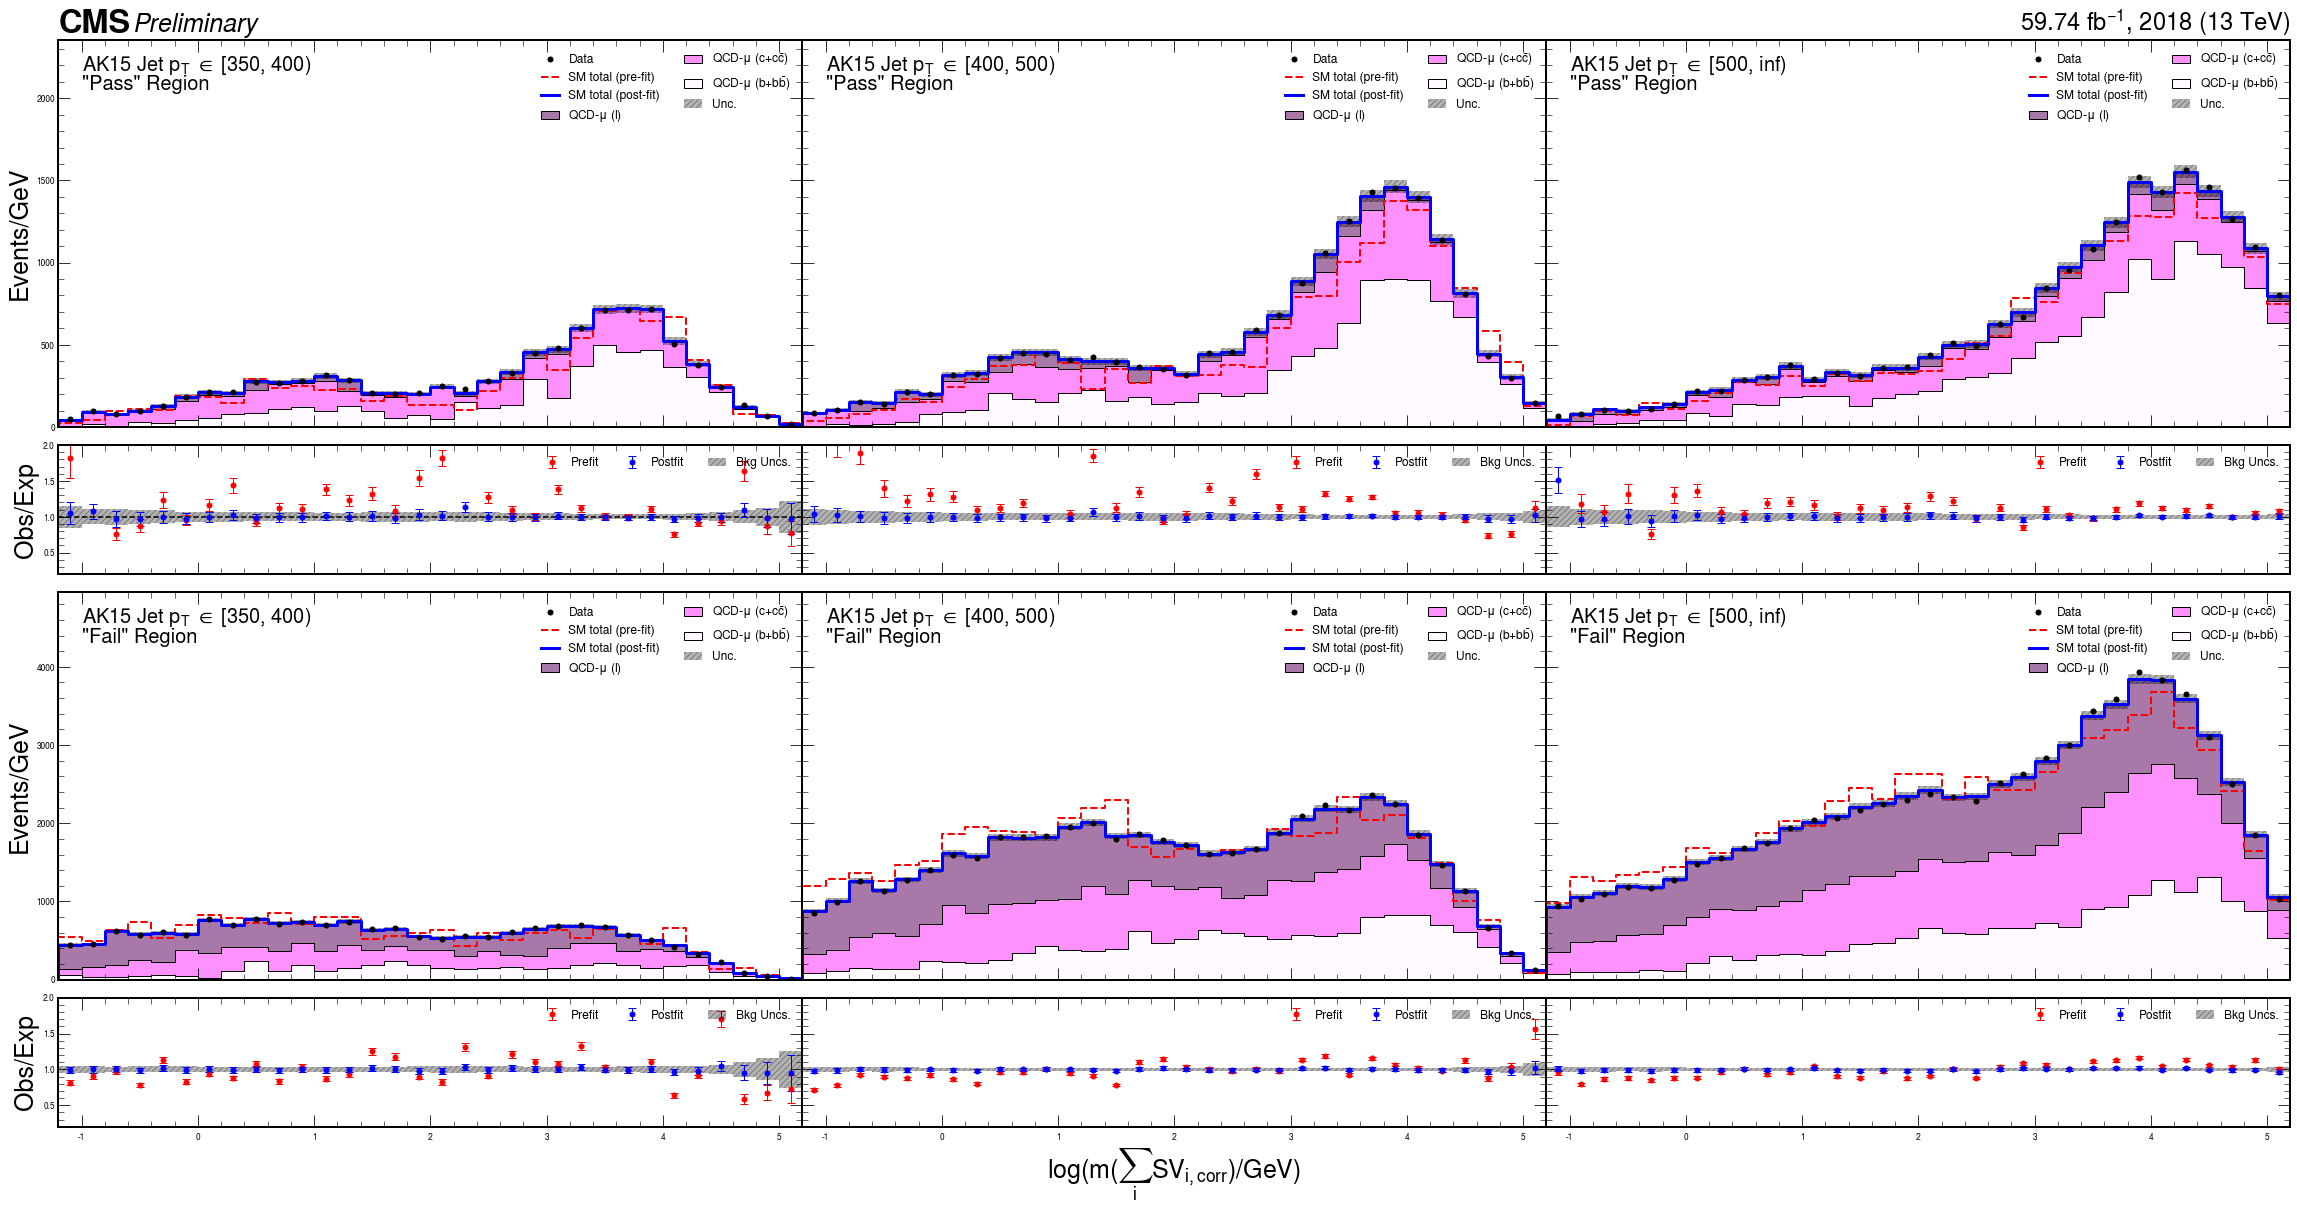

In [43]:
## year, category
year = '2018'
lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "35.92",
        '2017': "41.53",
        '2018': "59.74"
    }
lumi=lumis[year]
saveplot = True
f = up.open("../hists/doublebsf"+year+".postfit")

plot_postfit(f, year, processes, saveplot)

In [9]:
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load, save
import mplhep as hep
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
plt.style.use(hep.style.CMS)

year = '2016'
lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "36.31",
        '2017': "41.53",
        '2018': "59.74"
    }
lumi=lumis[year]

hists = load('../hists/doublebsf'+year+'.scaled')
bkg_hists = copy.deepcopy(hists['bkg'])
signal_hists = copy.deepcopy(hists['sig'])
data_hists = copy.deepcopy(hists['data'])
if year == '2018':
    for k in data_hists:
        data_hists[k].scale(2.)

In [3]:
###
# Table
###
sum=0
for p in bkg_hists['ZHbbvsQCD'].identifiers('process'):
    print(p, bkg_hists['ZHbbvsQCD'].integrate('process',str(p)).values()[()].sum())
    sum+=bkg_hists['ZHbbvsQCD'].integrate('process',str(p)).values()[()].sum()
print('Expected',sum)
print('Observed',data_hists['ZHbbvsQCD'].integrate('process').values()[()].sum())

QCD-$\mu$ (bb) 20064.84012885695
QCD-$\mu$ (b) 34804.98155708514
QCD-$\mu$ (cc) 20557.017787602916
QCD-$\mu$ (c) 48771.37886735782
QCD-$\mu$ (l) 85486.9927142987
Expected 209685.21105520154


KeyError: ()

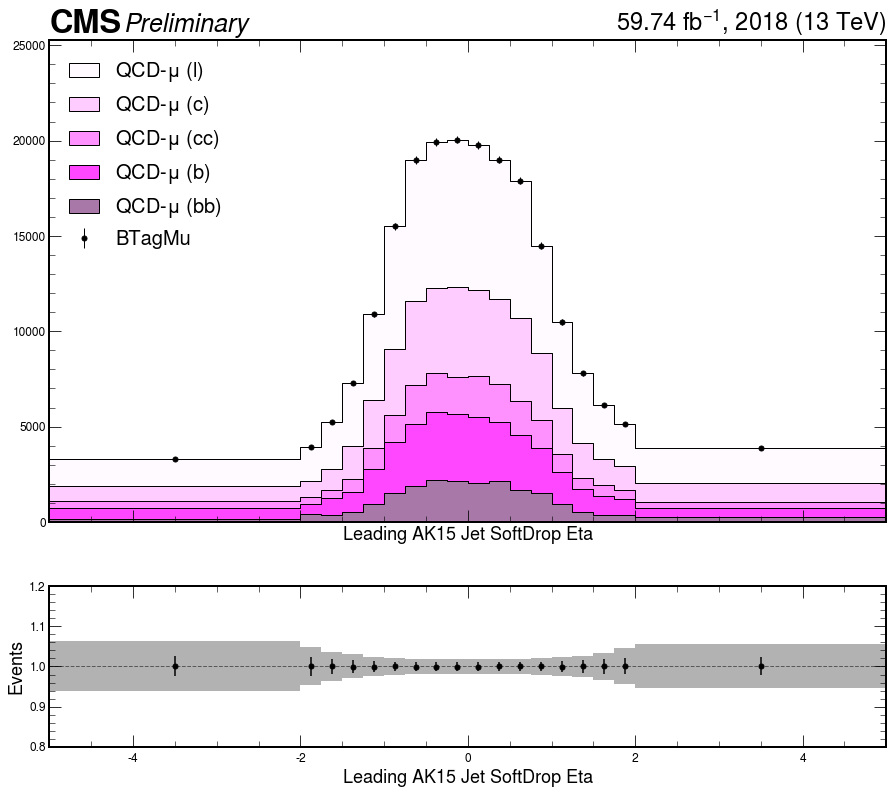

In [35]:
###
# Stack plots
###

from cycler import cycler
from collections import defaultdict, OrderedDict
from coffea import hist, processor 
from coffea.hist import plot

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#fffaff','#ffccff','#ff91ff','#ff47ff','#a879a8']

variable='fj1eta'

fig, (ax, rax) = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
ax.set_prop_cycle(cycler(color=colors))

line_opts = {'linestyle':'-', 'linewidth':2}
line_opts2 = {'linestyle':'dashdot', 'linewidth':5}
error_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10.}

bkg_hists_QCD=bkg_hists[variable]
#bkg_hists_QCD=bkg_hists_QCD.sum('tau21','fj1eta','ZHbbvsQCD')#.rebin('fj1pt',hist.Bin('fj1pt', 'fj1pt', [350, 450, 550, 700, 2500]))

plot.plot1d(bkg_hists_QCD,
                overlay="process",
                ax=ax,
                #error_opts=error_opts,
                clear=False,
                line_opts=line_opts,
                stack=True,
                fill_opts=fill_opts,
                )
data_hists_QCD=data_hists[variable]
#data_hists_QCD=data_hists_QCD.sum('tau21','fj1eta','ZHbbvsQCD').integrate('process','BTagMu')#.rebin('fj1pt',hist.Bin('fj1pt', 'fj1pt', [350, 450, 550, 700, 2500]))

plot.plot1d(data_hists_QCD,            
            overlay="process",
            ax=ax,
            clear=False,
            error_opts=data_err_opts
            )

plot.plotratio(data_hists_QCD.integrate('process'), 
               bkg_hists_QCD.integrate('process'),
               ax=rax,
               error_opts=data_err_opts,
               denom_fill_opts={},
               guide_opts={},
               unc='num'
               )
ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
#ax.set_yscale('log')
ax.set_ylabel("",fontsize=25)
ax.set_ylim(.0, ax.get_ylim()[1]*1.2)
#ax.set_xlabel("SV mass",fontsize=25)
#ax.set_xlim(.0, 1.)
rax.set_ylim(0.8,1.2)
leg = ax.legend(ncol=1, loc='upper left',fontsize=20)
hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25)

In [36]:
###
# Reweighting
###

num=data_hists['template'].sum('ZHbbvsQCD').integrate('process').values()[()]#[:,:,:]
den=bkg_hists['template'].sum('ZHbbvsQCD').integrate('process').values()[()]#[:,:,:]
den[den<=0]=1.
reweighting=num/den

for msv in range (reweighting.shape[0]):
    for pt in range (reweighting.shape[1]):
        for process in bkg_hists['template'].values().keys():
                bkg_hists['template'].values()[(process)][msv,pt]=reweighting[msv,pt]*bkg_hists['template'].values()[(process)][msv,pt]

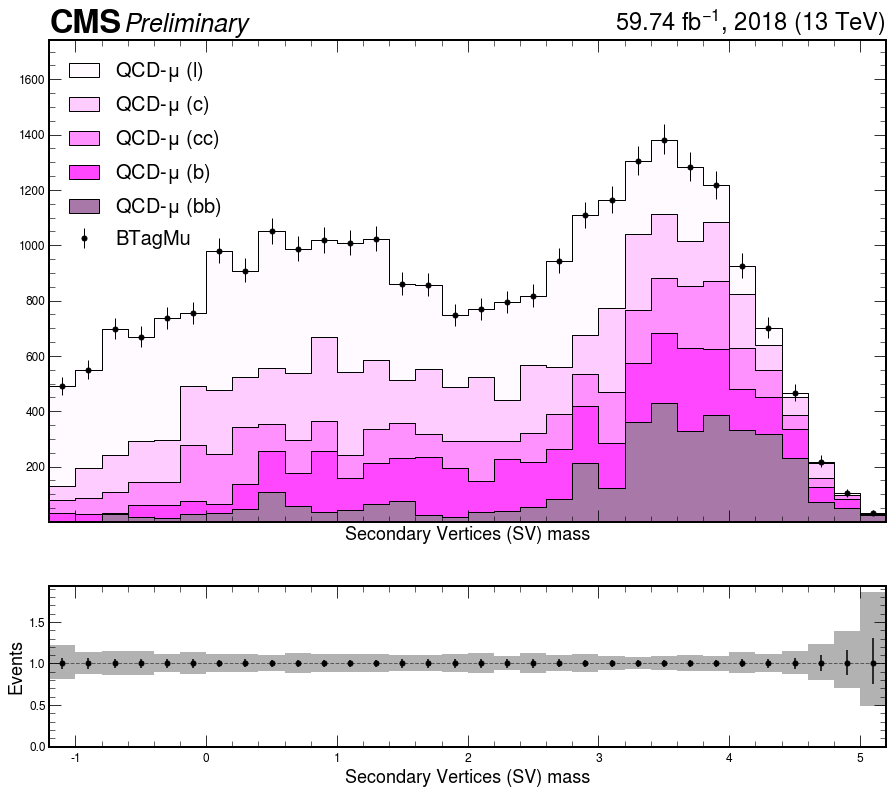

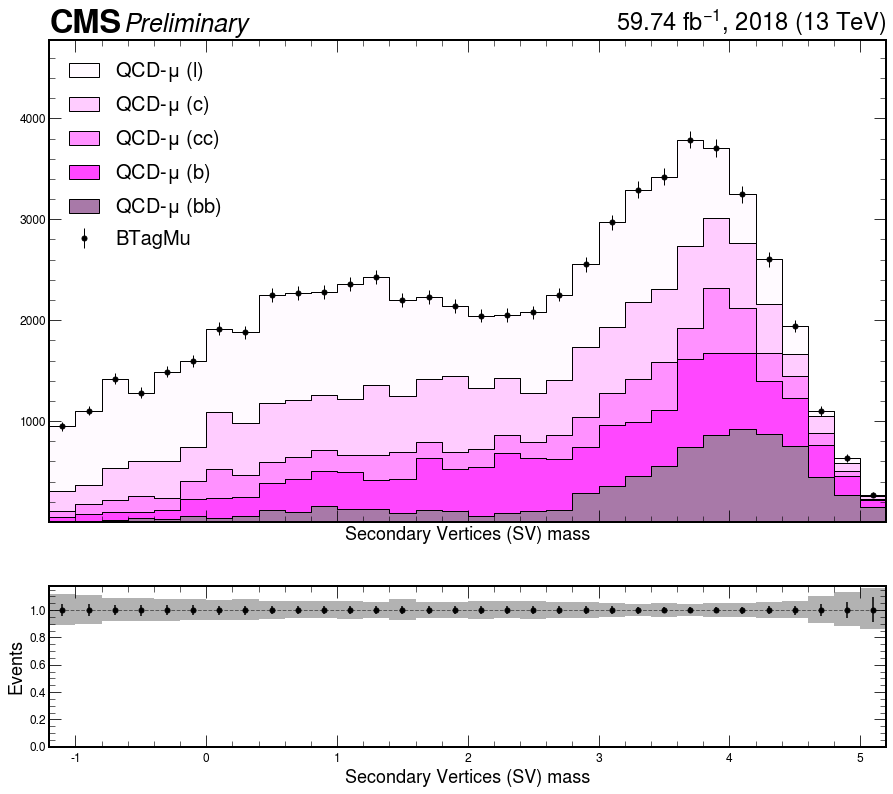

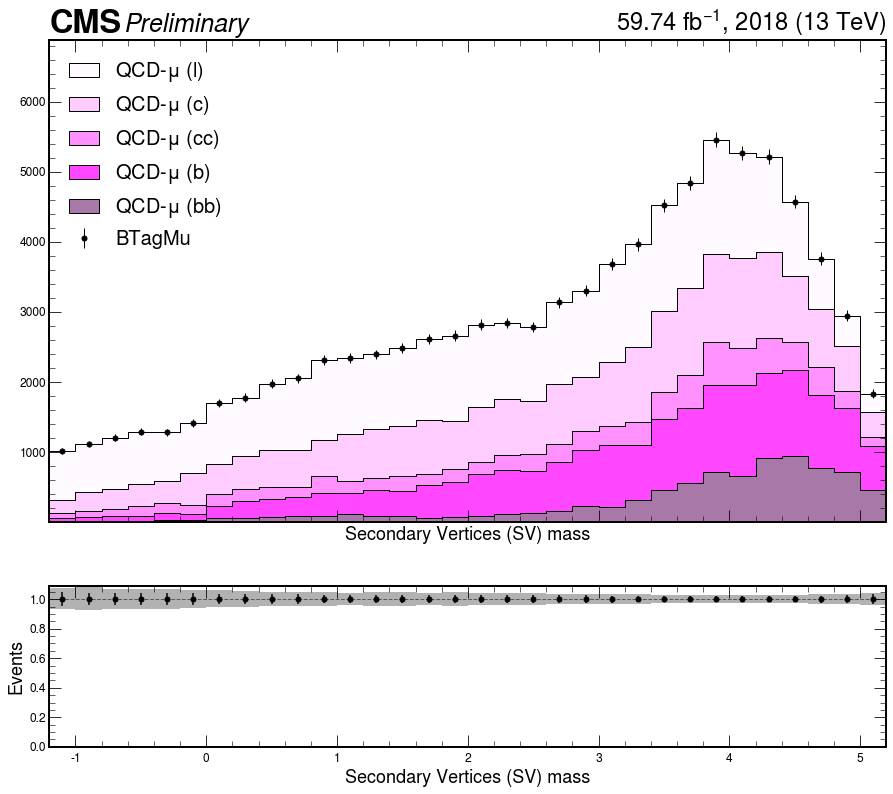

In [37]:
###
# Stack plot of SV mass
###

from cycler import cycler
from collections import defaultdict, OrderedDict
from coffea import hist, processor 
from coffea.hist import plot

#pt_binning=[[350, 400],[400, 450], [450, 500], [500, 600], [600, 900], [900, 2500]]
pt_binning=[[350, 400],[400, 500], [500, 2500]]
#pt_binning=[[350, 400],[400, 450], [450, 2500]]

def plot_svmass(bin_index):
    plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
    fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
    error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
    nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
    data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
    colors = ['#fffaff','#ffccff','#ff91ff','#ff47ff','#a879a8']


    fig, (ax, rax) = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    ax.set_prop_cycle(cycler(color=colors))

    line_opts = {'linestyle':'-', 'linewidth':2}
    line_opts2 = {'linestyle':'dashdot', 'linewidth':5}
    error_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10.}

    bkg_hists_QCD=bkg_hists['template']
    bkg_hists_QCD=bkg_hists_QCD.rebin('fj1pt',hist.Bin('fj1pt', 'fj1pt', pt_binning[bin_index]))
    bkg_hists_QCD=bkg_hists_QCD.sum('fj1pt','ZHbbvsQCD')
    

    plot.plot1d(bkg_hists_QCD,
                    overlay="process",
                    ax=ax,
                    #error_opts=error_opts,
                    clear=False,
                    line_opts=line_opts,
                    stack=True,
                    fill_opts=fill_opts,
                    )
    data_hists_QCD=data_hists['template']#.rebin('svmass',hist.Bin('svmass','SV mass', [-1.2, -0.8, -0.4, 0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0, 4.4, 4.8, 5.2]))
    data_hists_QCD=data_hists_QCD.rebin('fj1pt',hist.Bin('fj1pt', 'fj1pt', pt_binning[bin_index]))
    data_hists_QCD=data_hists_QCD.sum('fj1pt','ZHbbvsQCD')

    plot.plot1d(data_hists_QCD,            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                )

    plot.plotratio(data_hists_QCD.integrate('process'), 
                   bkg_hists_QCD.integrate('process'),
                   ax=rax,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.autoscale(axis='x', tight=True)
    #ax.set_yscale('log')
    ax.set_ylabel("",fontsize=25)
    ax.set_ylim(.01, ax.get_ylim()[1]*1.2)
    #ax.set_xlabel("SV mass",fontsize=25)
    #ax.set_xlim(.0, 1.)
    leg = ax.legend(ncol=1, loc='upper left',fontsize=20)
    hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)
    hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=25)

plot_svmass(0)
plot_svmass(1)
plot_svmass(2)
#plot_svmass(3)
#plot_svmass(4)

In [38]:
hists={
        'bkg': bkg_hists,
        'sig': signal_hists,
        'data': data_hists
    }
save(hists,'../hists/doublebsf'+year+'.scaled')

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

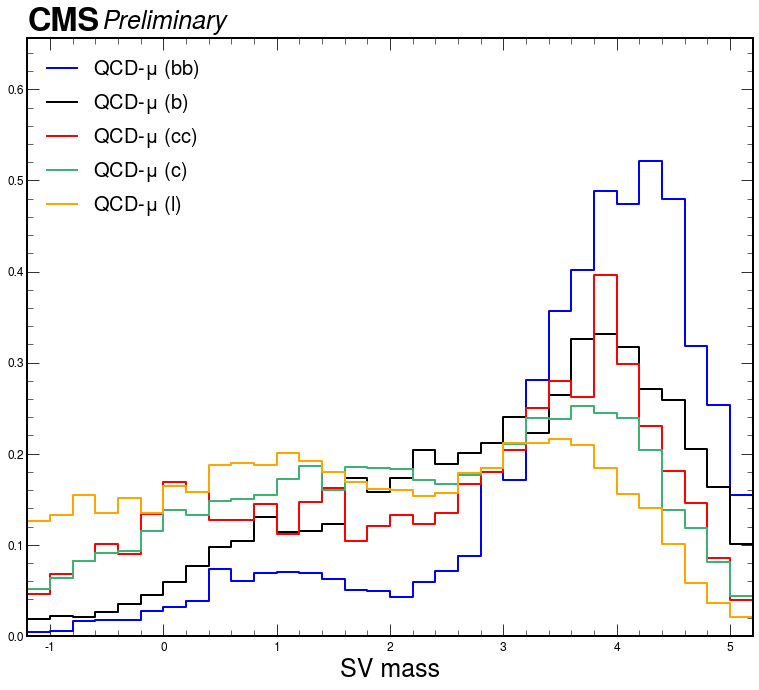

In [39]:
###
# Unstack plot of SV mass
###

from cycler import cycler
from collections import defaultdict, OrderedDict
from coffea import hist, processor 
from coffea.hist import plot

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#0000ff','#000000','#ff0000','#3cb371','#FFA500','#cccccc']


fig, ax = plt.subplots(figsize=(13,11), sharex=True)
ax.set_prop_cycle(cycler(color=colors))

line_opts = {'linestyle':'-', 'linewidth':2}
line_opts2 = {'linestyle':'dashdot', 'linewidth':5}
error_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10.}

bkg_hists_QCD=bkg_hists['template']
bkg_hists_QCD=bkg_hists_QCD.sum('fj1pt','ZHbbvsQCD')

plot.plot1d(bkg_hists_QCD,
                overlay="process",
                ax=ax,
                #error_opts=error_opts,
                clear=False,
                density=True,
                line_opts=line_opts,
                )


ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
#ax.set_yscale('log')
ax.set_ylabel("",fontsize=25)
ax.set_ylim(.0, ax.get_ylim()[1]*1.2)
ax.set_xlabel("SV mass",fontsize=25)
#ax.set_xlim(.0, 1.)
leg = ax.legend(ncol=1, loc='upper left',fontsize=20)
hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)

#data_hist=data_hists['template'].integrate('process').integrate('gentype').integrate('svmass')



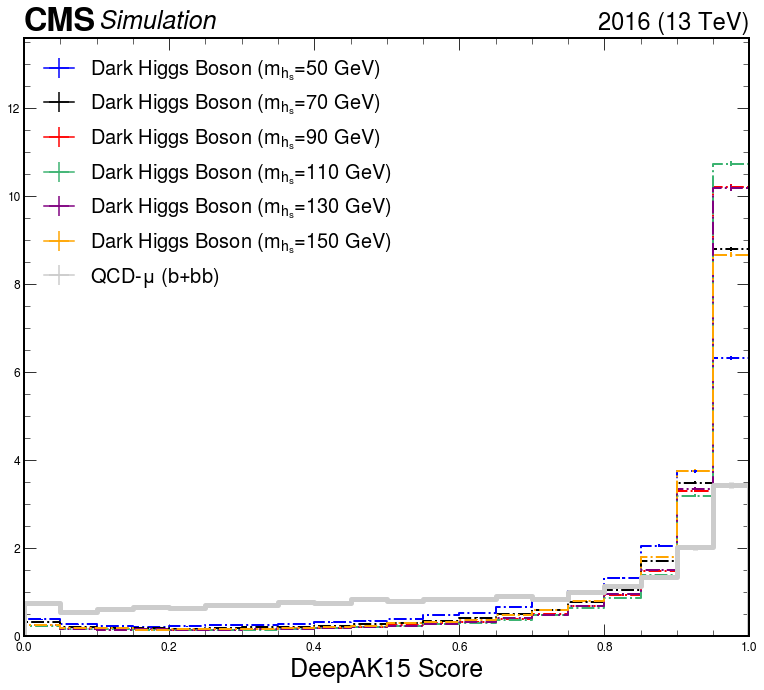

In [10]:
###
# N-1 of the fat jet tagger unstack plot
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler
from collections import defaultdict, OrderedDict
from coffea import hist, processor 
from coffea.hist import plot

process = hist.Cat("process", "Process", sorting="placement")
cats = ("process",)

bkg_hists_ZHbbvsQCD=bkg_hists['ZHbbvsQCD']
#bkg_hists_ZHbbvsQCD=bkg_hists_ZHbbvsQCD.integrate('process','QCD-$\mu$ (bb)')
bkg_map = OrderedDict()
bkg_map['QCD-$\mu$ (b+bb)'] = (['QCD-$\mu$ (bb)','QCD-$\mu$ (b)'],)
bkg_hists_ZHbbvsQCD=bkg_hists_ZHbbvsQCD.group(cats, process, bkg_map)

signal_hists_ZHbbvsQCD=signal_hists['ZHbbvsQCD']
signal_map = OrderedDict()
signal_map[r"Dark Higgs Boson ($m_{h_s}$=50 GeV)"] = ("Mz500_mhs50_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=70 GeV)"] = ("Mz500_mhs70_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=90 GeV)"] = ("Mz500_mhs90_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=110 GeV)"] = ("Mz500_mhs110_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=130 GeV)"] = ("Mz500_mhs130_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=150 GeV)"] = ("Mz500_mhs150_Mdm150*",)
signal_hists_ZHbbvsQCD=signal_hists_ZHbbvsQCD.group(cats, process, signal_map)

        
plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
#colors = ['#0000ff','#000000','#ff0000','#3cb371','#FFA500','#cccccc']
colors = ['#0000ff','#000000','#ff0000','#3cb371','#800080','#FFA500','#cccccc']

fig, ax = plt.subplots(figsize=(13,11), sharex=True)
ax.set_prop_cycle(cycler(color=colors))

line_opts = {'linestyle':'dashdot', 'linewidth':2}
line_opts2 = {'linestyle':'-', 'linewidth':5}
error_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10.}


plot.plot1d(signal_hists_ZHbbvsQCD,
                overlay="process",
                ax=ax,
                error_opts=error_opts,
                clear=False,
                density=True,
                line_opts=line_opts,
                )

plot.plot1d(bkg_hists_ZHbbvsQCD,
                #overlay="process",
                ax=ax,
                error_opts=error_opts,
                clear=False,
                density=True,
                line_opts=line_opts2,
                )

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
#ax.set_yscale('log')
ax.set_ylabel("",fontsize=25)
ax.set_ylim(.0, ax.get_ylim()[1]*1.2)
ax.set_xlabel("DeepAK15 Score",fontsize=25)
ax.set_xlim(.0, 1.)
leg = ax.legend(ncol=1, loc='upper left',fontsize=20)
hep.cms.text(ax=ax, loc=0, text='Simulation',fontsize=25)
hep.cms.lumitext(ax=ax, text=year+" (13 TeV)",fontsize=25) 
    

#coffee = plt.text(0., 1., u"☕ "+'Signal Region', fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

os.system('mkdir -p ../plots/doublebsf/prefit/'+year+'/')
plot_path = os.path.abspath('../plots/doublebsf/prefit/'+year+'/') 
plot_name = 'unstack_'+year+'_ZHbbvsQCD.png'
fig.savefig(os.path.join(plot_path, plot_name))


